# Preprocessing single cell ATAC-seq and Multiome data


## Content

1. Introduction

    - Why analysing chomatin accessibility
        - Chromatin state and regulatory elements
    - Single cell ATAC and 10x Multiome Assay
        - Tn5 transposases
        - Sequencing of fragments
    - Sparsity of scATAC data
    - The definition of features
        - The lack of pre-defined features
        - Peak calling
            - Harmonizing features across multiple samples
            - Re-calling peaks after initial clustering to not miss cluster specific peaks of small clusters
        - Binarization vs counts

2. Dataset and input files (w/ predefined peaks)

    - Neurips data set: 10x Multiome data of BMMCs from 12 donors sequenced across 4 sites (-> nested batch effects)

3. Sample-level QC
    
    - Number of cells, summary of total reads TSS score etc.
    
4. Cell-level QC

    - Fragment counts (read counts)
    - TSS score (and reads in peaks frac)
    - blacklist regions
    - Nucleosome signal
    - doublet score
    
5. Normalisation (-> Binarization?)

6. (optional) Feature selection

7. Dim Reduction: TFIDF and SVD (-> LSI)

8. Visualisation (as in RNA)

9. Refined peak calling by clusters
    - MACS2 within ArchR


**Note on packages:**

    - Python: Muon, Scanpy
    - R: ArchR, MACS2, Signac

# Introduction

## Why analyzing chomatin accessibility data?

Every cell of an organism shares the same DNA with the same set of functional units referred to as genes. but, what determines the incredible diversity of cells reaching from natural killer cells of the immune system to neurons transmitting electrical impulses through our body? In the previous chapters, we saw that cell identity and function can be defined by which genes are expressed. This, in turn, is controlled by a complex interplay of chemical modification such as DNA methylation, histone modifications that largely determine chromatin accessibility and transcription factors binding (see [this 2 minute video on epigenetics and the regulation of gene activity](https://www.youtube.com/watch?v=XelGO582s4U); credits to Nicole Ethen from the Simpson Querrey Center for Epigenetic Medicine, University of Illinois, **Reference not official yet**). 


- Single cell ATAC and 10x Multiome Assay
    - Tn5 transposases
    - Sequencing of fragments
    



- Sparsity of scATAC data
- The definition of features
    - The lack of pre-defined features
    - Peak calling
        - Harmonizing features across multiple samples
        - Re-calling peaks after initial clustering to not miss cluster specific peaks of small clusters
    - Binarization vs counts
- Not yet best practices, but well-working methods

# Not yet best practices, but well-working methods

We are aware, that for this chapter best practices are yet to be defined. Due to the novelty of the experimental procedure, several new methods and analyisis workflows are being developed and further benchmarks are required. Therefore, we make our recommendations based on a benchmark of computational methods to process scATAC-seq data by {cite:t}`chen2019assessment` and by comparing approaches applied in the current main software packages for scATAC-seq data analysis as reviewed by {cite:t}`baek2020single`. Additionally, we consider good practices of analysing bulk ATAC-seq data, where several concept are transferrable to scATAC-seq data. A recent review on processing bulk ATAC-seq data has been published by {cite:t}`yan2020reads`.


# The workflow

To enable a smooth transition from previous chapters, we decided to use muon as the central framework to work with multimodal data and modalities other than scRNA-seq. In this notebook we showcase a slim analysis workflow where we make use of a predefined peak-by-cell count matrix. This is a standard output of the [cellrange-atac](https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/what-is-cell-ranger-atac) (scATAC assay) or [cellranger-arc](https://support.10xgenomics.com/single-cell-multiome-atac-gex/software/pipelines/latest/what-is-cell-ranger-arc) (10X multiome assay) processing pipeline.

**overview figure**

Especially for data sets with lower cell heterogeneity such as FACS sorted cells the proposed analysis steps are likely to be sufficient. For complex data sets, especially if there are cell states representing only a small fraction of the total number of cells, it is suggested to rerun the peak calling within clusters of similar cells. This prevents to lose cell type specific peaks that might get masked by the noise of more abundant cell types. If the reader is interested in exploring this option, we refere to chapter XXX.


# The dataset and input files (predefined features)

To showcase the processing of scATAC-seq data, we use a 10x Multiome data set generated for a single cell data integration challenge at the NeurIPS conference 2021 {cite:p}`luecken2021sandbox`. A hallmark of this data set is that it contains a nested batch structure of multiple donors sequenced at multiple institutions.

Our starting point is the output of cellranger-arc, the software solution of 10x to perfom alignment, peak calling and initial QC of their 10x Multiome assay.  By default, the output contains the snRNA-seq as well as the scATAC-seq data. Since the preprocessing of snRNA-seq data has been described extensively in previous chapters, here, we only discuss the chromatin accesibility data. In later chapters we integrate the scRNA-seq data if the same set of samples, which has been processed according to the best practices described earlier in this book.

# Loading packages

In [1]:
# Major framework to work with multimodal single cell data
import muon as mu
from muon import atac as ac

# Scanpy and general useful pathon packages
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np

# Customised plots
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting figure parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

In [3]:
# Check the working directory
os.getcwd()

'/storage/groups/ml01/workspace/christopher.lance/mm_best/src/scATAC'

In [10]:
# In case you would like to change the working directory
os.chdir('/storage/groups/ml01/workspace/christopher.lance/mm_best/src/scATAC')

In [4]:
adata = sc.read_h5ad('/lustre/groups/ml01/workspace/lisa.sikkema/czi_tissue_references/data/blood/benchmark_healthy_data_blood.h5ad')

AnnDataReadError: Above error raised while reading key '/layers' of type <class 'h5py._hl.group.Group'> from /.

# Loading data

## From .h5 file with automated detection of fragment files

Starting from the 10x output of aggregated peaks, muon automatically detects and loads fragment files and peak_annotations.

In [5]:
mdata = mu.read_10x_h5("/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from /storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added peak annotation from /storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_fragments.tsv.gz


Both modalities of the 10x multiome assay were added to the multiome object.

Let's take a quick look mudata object as described in detail in chapter XXX. We can see that the atac modality contains two entries in the unstructured data slot atac.uns that contains the peak annotation and the path to the fragment file.

In [6]:
# As compact text output
mdata

MuData object with n_obs × n_vars = 131515 × 194756
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	131515 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	131515 x 158155
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

Or as interactive HTML display:

In [7]:
# As intective html output
with mu.set_options(display_style = "html", display_html_expand = 0b000):
    display(mdata)

MuData object with n_obs × n_vars = 131515 × 194756
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	131515 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	131515 x 158155
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

# TEMP: subset to 5 samples

In [8]:
mdata.obs['samle_tag'] = [s.split('-')[1] for s in list(mdata.obs_names)]

In [9]:
# Add sample information
sample_info = pd.read_csv('/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/aggr.csv')

In [10]:
sample_info['samp_number'] = [i for i in range(1,15)]

In [11]:
# Selected samples: 1 2 4 5 7
sample_info

library_id                                     atac_fragments  \
0    site1_donor1  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
1    site1_donor2  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
2    site1_donor3  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
3    site2_donor1  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
4    site2_donor4  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
5    site2_donor5  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
6    site3_donor1  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
7    site3_donor6  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
8    site3_donor7  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
9    site3_donor3  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
10  site3_donor10  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
11  site4_donor09  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
12   site4_donor1  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
13   site4_donor8  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   

                                  per_barcode_metrics  \
0   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
1   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
2   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
3   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
4   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
5   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
6   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
7   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
8   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
9   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
10  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
11  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
12  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   
13  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...   

                                    gex_molecule_info  samp_number  
0   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            1  
1   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            2  
2   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            3  
3   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            4  
4   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            5  
5   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            6  
6   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            7  
7   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            8  
8   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...            9  
9   /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...           10  
10  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...           11  
11  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...           12  
12  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...           13  
13  /mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...           14

In [12]:
samp_subset = ['1', '2', '4', '5', '7']

In [13]:
mdata = mdata[[i in samp_subset for i in mdata.obs.samle_tag],:].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
mdata

MuData object with n_obs × n_vars = 34813 × 194756
  obs:	'samle_tag'
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	34813 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	34813 x 158155
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [15]:
tag_batch_dict = {
    '1':'site1_donor1',
    '2':'site1_donor2',
    '4':'site2_donor1',
    '5':'site2_donor4',
    '7':'site3_donor1'
}

In [16]:
mdata.obs['batch'] = mdata.obs['samle_tag'].map(tag_batch_dict)

In [17]:
mdata

MuData object with n_obs × n_vars = 34813 × 194756
  obs:	'samle_tag', 'batch'
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	34813 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	34813 x 158155
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

## Optional: Alternative h5ad loading

Add link to muon for reading snapATAC files for reference

In [18]:
#neurips_adata = sc.read_h5ad("/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix.annotated.h5ad")


In [19]:
#adata_rna = neurips_adata[:,neurips_adata.var.feature_types=='Gene Expression']
#adata_atac = neurips_adata[:,neurips_adata.var.feature_types=='Peaks']

In [21]:
#mdata_fromh5ad = mu.read_h5ad("/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix.annotated.h5ad",
#                             mod='atac')


In [22]:
#mdata_fromh5ad = mu.MuData(neurips_adata, feature_types_names={'Gene Expression':'rna', 'Peaks':'atac'})

In [23]:
#mdata_fromh5ad

In [24]:
# Adding fragment files, annotations and QC metrics manually

# Calculating QC metrics

## Subsetting to the ATAC modality
To calculate QC metrics, we subset to the sc-ATAC modality and therefore work with the annadata object.

In [18]:
atac = mdata.mod['atac']

Let's take a look at the .uns slot, printing the peak annotation and path to the fragment file.

In [19]:
atac.uns

OverloadedDict, wrapping:
	OrderedDict([('atac', OrderedDict([('peak_annotation',                                peak  distance peak_type
gene_name                                              
MIR1302-2HG         chr1:9776-10668    -18886    distal
AL627309.5       chr1:180726-181005     -6865    distal
AL627309.5       chr1:181117-181803     -7256    distal
AL627309.5       chr1:183983-184830    -10122    distal
AL627309.5       chr1:191133-192055    -17272    distal
...                             ...       ...       ...
AC233755.1   KI270726.1:41476-42297        33  promoter
AC213203.2   KI270713.1:21434-22336     10192    distal
AC213203.2   KI270713.1:26002-26720      5808    distal
AC213203.2   KI270713.1:29629-30491      2037    distal
AC213203.1   KI270713.1:36926-37828      1520    distal

[201507 rows x 3 columns])])), ('files', OrderedDict([('fragments', '/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_fragments.tsv

## Calculating (and adding) QC metrics

First, we make use of the calculate_qc_metrics function in scanpy to calculate the total number of fragments and number of features per cell. The total counts, we also log transform as an additional representation often suitable for plotting. To make clear, what the counts refer to, we modify the default qc metric names to total_fragment_counts and n_features_per_cell

Before we add the QC metrics, let's check again the slots in the atac object

In [20]:
atac

AnnData object with n_obs × n_vars = 34813 × 158155
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

### Total count and number of features

In [21]:
# calculate general qc metrics using scanpy
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

# Renome columns
atac.obs.rename(columns = {'n_genes_by_counts':'n_features_per_cell', 'total_counts':'total_fragment_counts'}, inplace = True)

# log-transform total counts
atac.obs['log_total_fragment_counts'] = np.log10(atac.obs['total_fragment_counts'])

### Nucleosome signal

Next, we calculate scATAC specific QC metrics, the nucleosome_signal and tss_enrichment score.
The default number fragment n to analyze is 10e4*n_cells and takes approximately 15 minutes. Decrease n for lower precise mesurements, if you anly wnat to test the pipline.

In [22]:
# Calculate the nucleosome signal across cells
ac.tl.nucleosome_signal(atac, n=10e3*atac.n_obs) #set n=10e3*atac.n_obs for rough estimate but faster run time

Reading Fragments: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 348130000/348130000 [15:29<00:00, 374678.97it/s]


Let's take a look at cell with high an low nucleosome signals. Therefore, we add a category to atac.obs, which indicates cells with a nucleosome profile corresponding to high versus low nucleosome_signals.

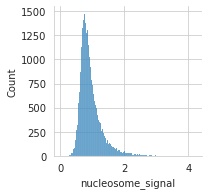

In [23]:
# Plot distribution of the nucleosome_signal across all cells
mu.pl.histogram(atac, "nucleosome_signal")
#sc.pl.violin(atac, "nucleosome_signal")

In [24]:
# Choose threshold for the nucleosome signal (ns) and add information to atac.obs
nuc_signal_threshold = 3
atac.obs['nuc_signal_filter'] = ['NS_FAIL' if ns > nuc_signal_threshold else 'NS_PASS' for
                                 ns in atac.obs['nucleosome_signal'] ]

# Print number cells not passing nucleosome signal threshold
atac.obs['nuc_signal_filter'].value_counts()

NS_PASS    34789
NS_FAIL       24
Name: nuc_signal_filter, dtype: int64

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


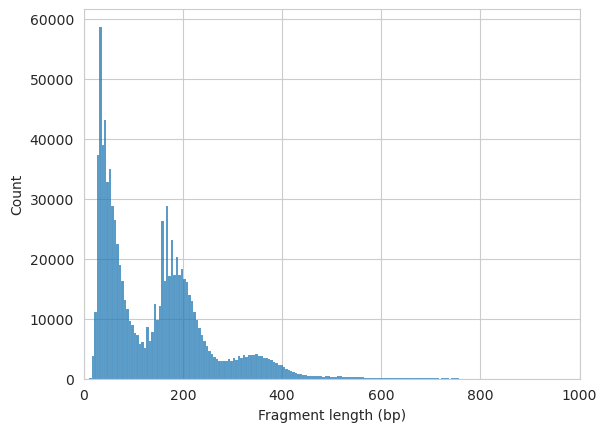

In [25]:
# Plot fragment size distribution
ac.pl.fragment_histogram(atac[atac.obs['nuc_signal_filter']=='NS_PASS'],
                         region="chr1:1-2000000")

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.17s/it]


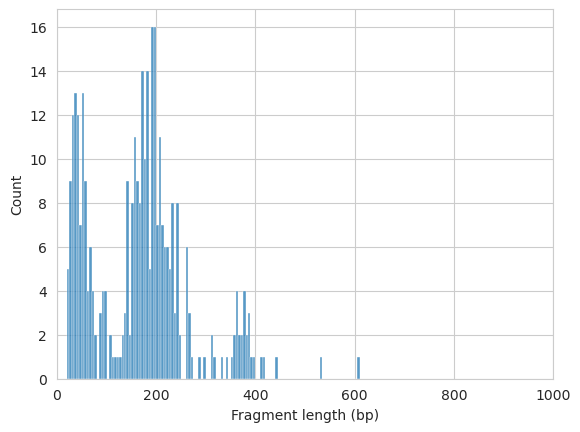

In [26]:
# Plot fragment size distribution
ac.pl.fragment_histogram(atac[atac.obs['nuc_signal_filter']=='NS_FAIL'],
                         region="chr1:1-2000000") #"chr1:1-2000000"

In the above histogram we see that the ratio of mononucleosomal to nucleosome-free fragments is unexpectedly high. Therefore we exclude these cells.

### TSS enrichment

As a next QC metric we assess the signal to noise ratio in each cell. To do so on can consider the fraction of reads that map to peak regions, or the enrichment of fragment in the region of transcription start sites (TSS).

In [27]:
# calculate TSS enrichment scores (5 min runtime)
# n_tss describes the number of TSS we consider for the estimate of the TSS enrichment score
tss = ac.tl.tss_enrichment(mdata, n_tss=3000)

Fetching Regions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:34<00:00, 10.93it/s]


Let's plot the distribution of the TSS enrichment score 1kb up- and downstream of transciption start sites.

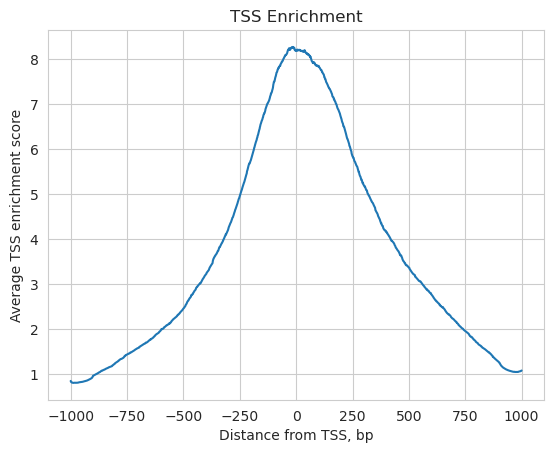

In [28]:
ac.pl.tss_enrichment(tss)

Let's take a look at what has been added to our mdata object.

In [58]:
mdata

MuData object with n_obs × n_vars = 34813 × 194756
  obs:	'samle_tag', 'batch'
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	34813 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	34813 x 158155
      obs:	'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'atac', 'files'

In [59]:
os.getcwd()

'/storage/groups/ml01/workspace/christopher.lance/mm_best/src/scATAC'

In [60]:
# save
mdata.write_h5mu('muon_data/neurips_incl_qc.h5mu')

/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'samle_tag' as categorical
/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parame

### Optional: Adding 10x QC metrics

 In addition to the aggregated count matrices, 10X provides additional QC metrics on a sample level. This we need to load seperatly from the cellranger output directories per sample. We include cell and sample level qc metrics.

In [42]:
# Load 10X QC metrics by sample

cell_qc_dict = {}
sample_qc_dict = {}

for samp in ['s1d1', 's1d2', 's2d1', 's2d4', 's3d1']:
    
    print('Reading 10x QC files from sample', samp)
    
    per_barcode_metrics = pd.read_csv('/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/'+samp+'/cellranger_out/per_barcode_metrics.csv',
                                          index_col=0)
    sample_summary = pd.read_csv('/storage/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/'+samp+'/cellranger_out/summary.csv',
                                          index_col=0)
    
    cell_qc_dict[samp] = per_barcode_metrics
    sample_qc_dict[samp] = sample_summary


Reading 10x QC files from sample s1d1
Reading 10x QC files from sample s1d2
Reading 10x QC files from sample s2d1
Reading 10x QC files from sample s2d4
Reading 10x QC files from sample s3d1


Let's check which qc metrics are available

In [43]:
# barcode-level metrics
cell_qc_dict['s1d1'].columns

Index(['gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason',
       'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads',
       'gex_conf_exonic_reads', 'gex_conf_intronic_reads',
       'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads',
       'gex_conf_exonic_dup_reads', 'gex_exonic_umis',
       'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads',
       'gex_conf_intronic_dup_reads', 'gex_intronic_umis',
       'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count',
       'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq',
       'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads',
       'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments',
       'atac_peak_region_cutsites'],
      dtype='object')

In [44]:
# sample-level metrics
sample_qc_dict['s1d1'].columns

Index(['Genome', 'Pipeline version', 'Estimated number of cells',
       'Feature linkages detected', 'Linked genes', 'Linked peaks',
       'ATAC Confidently mapped read pairs',
       'ATAC Fraction of genome in peaks',
       'ATAC Fraction of high-quality fragments in cells',
       'ATAC Fraction of high-quality fragments overlapping TSS',
       'ATAC Fraction of high-quality fragments overlapping peaks',
       'ATAC Fraction of transposition events in peaks in cells',
       'ATAC Mean raw read pairs per cell',
       'ATAC Median high-quality fragments per cell',
       'ATAC Non-nuclear read pairs', 'ATAC Number of peaks',
       'ATAC Percent duplicates', 'ATAC Q30 bases in barcode',
       'ATAC Q30 bases in read 1', 'ATAC Q30 bases in read 2',
       'ATAC Q30 bases in sample index i1', 'ATAC Sequenced read pairs',
       'ATAC TSS enrichment score', 'ATAC Unmapped read pairs',
       'ATAC Valid barcodes', 'GEX Fraction of transcriptomic reads in cells',
       'GEX Mean 

Plot sample-level QC metrics

In [51]:
# Select first sample as df to start
samp_qc_df = sample_qc_dict[list(sample_qc_dict.keys())[0]]

# Add remaining dfs
for samp in list(sample_qc_dict.keys())[1:]:
     samp_qc_df = pd.concat([samp_qc_df, sample_qc_dict[samp]]) 

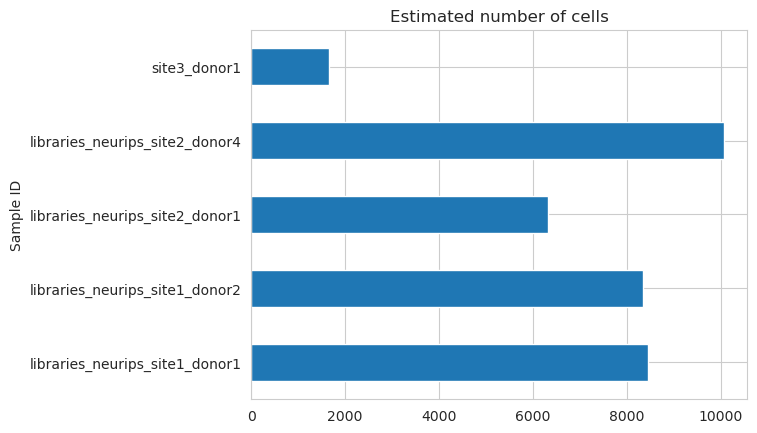

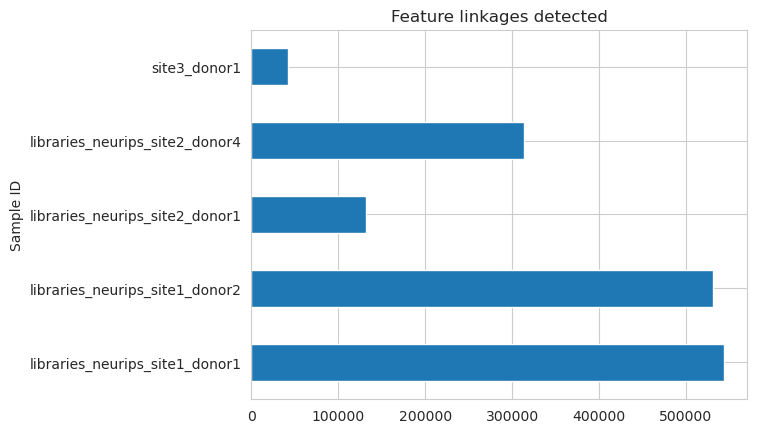

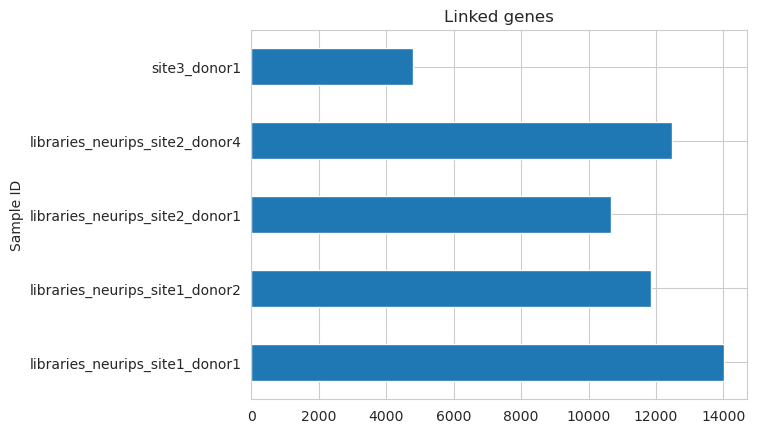

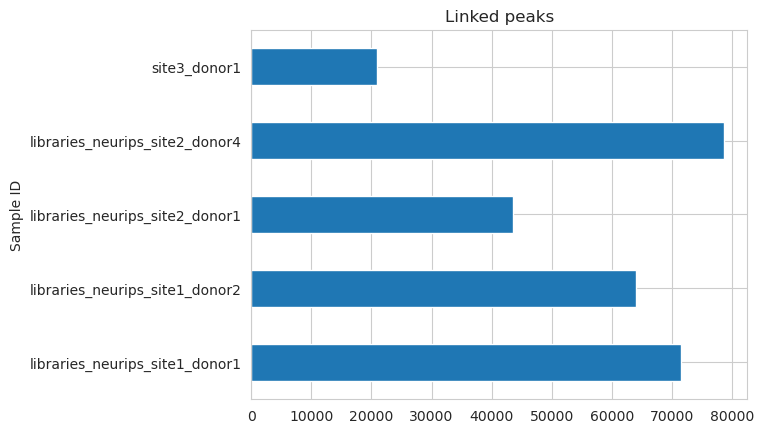

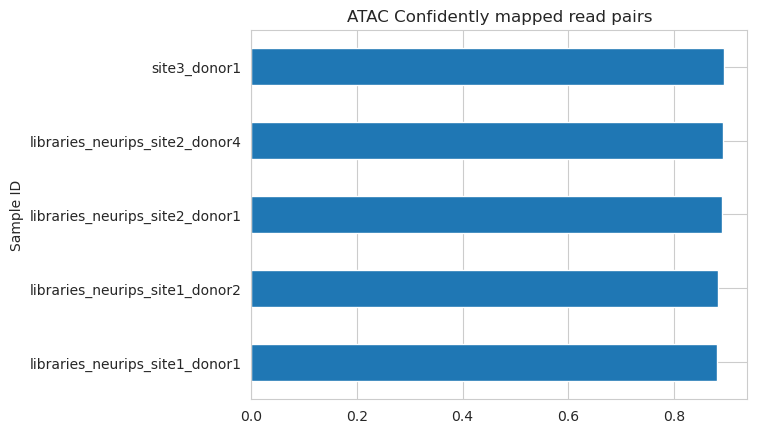

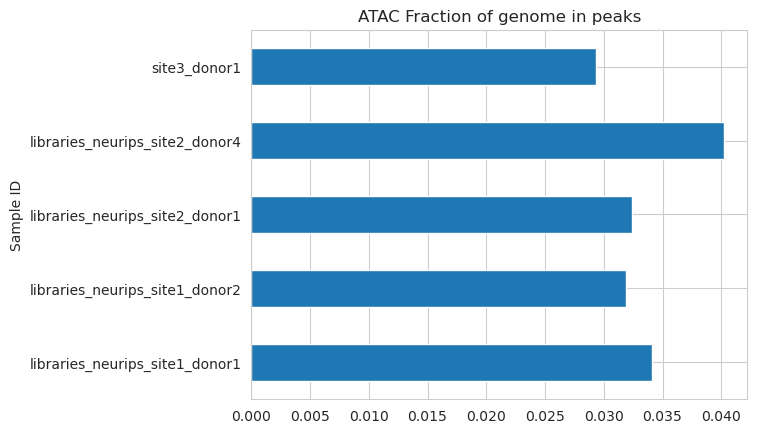

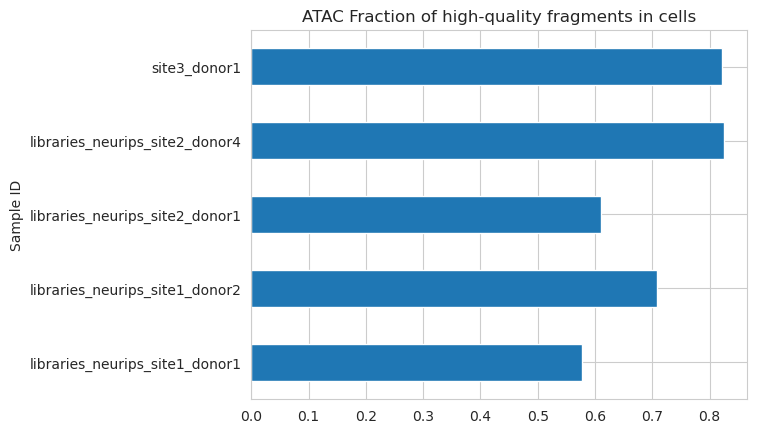

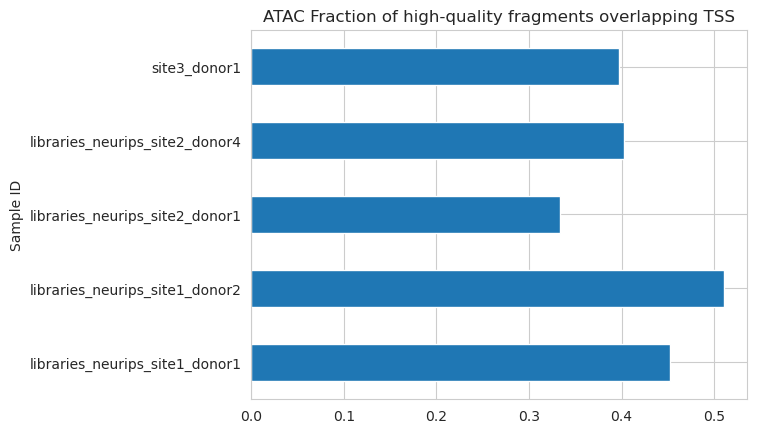

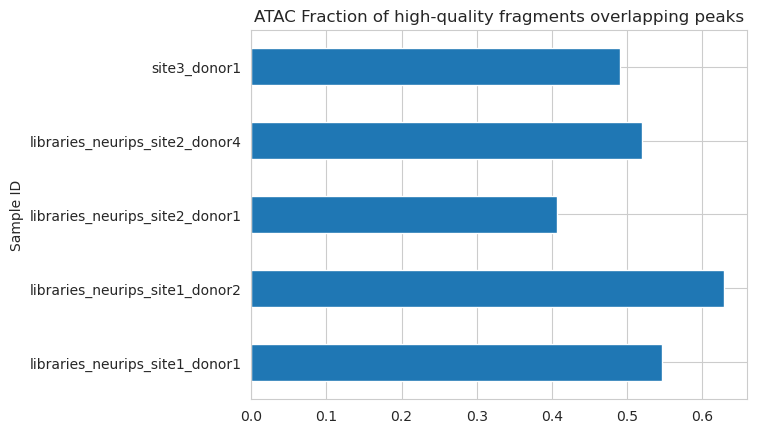

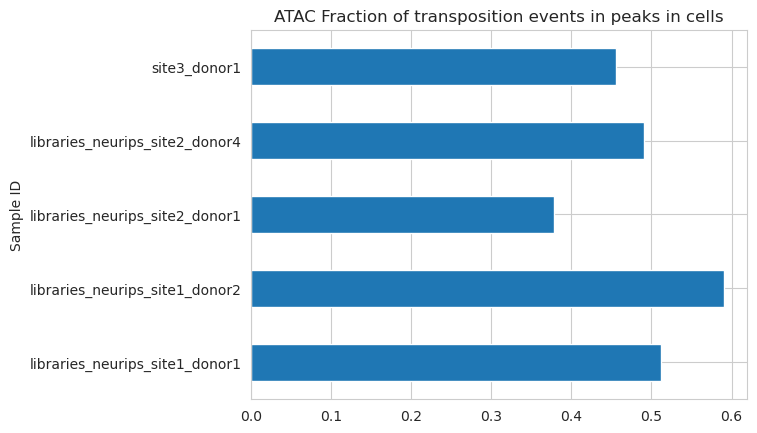

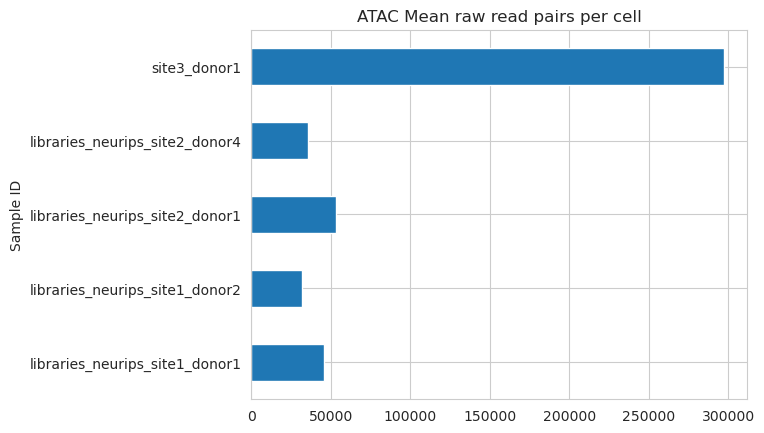

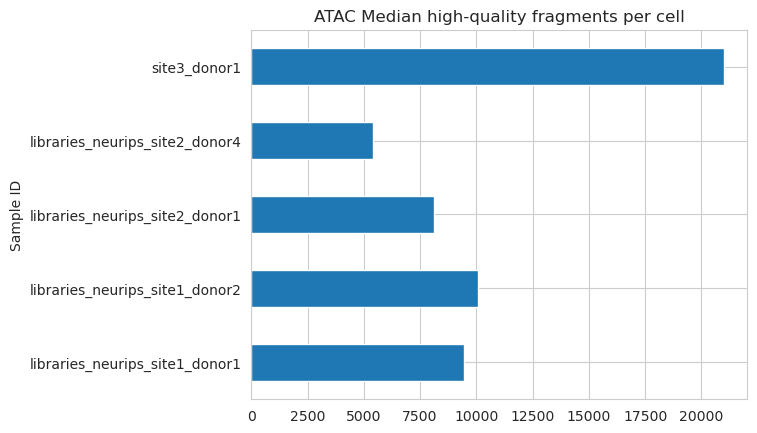

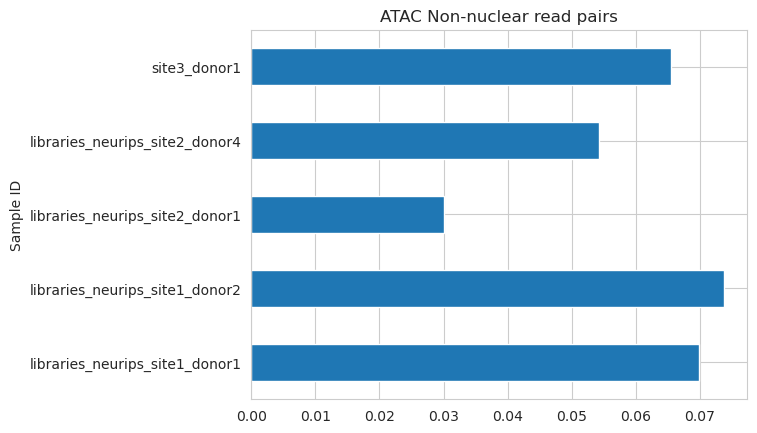

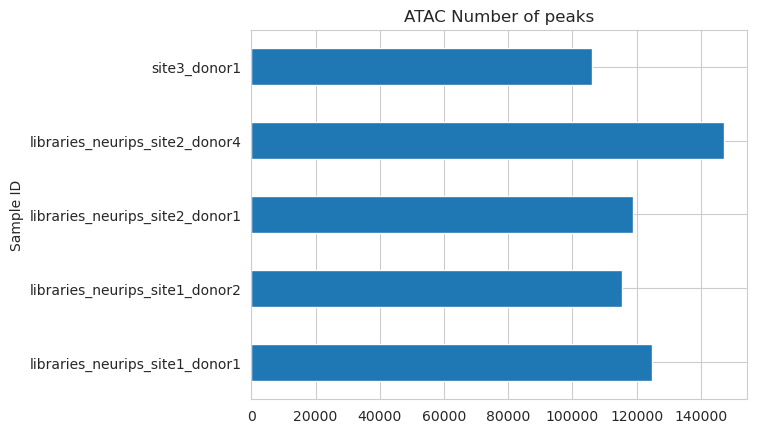

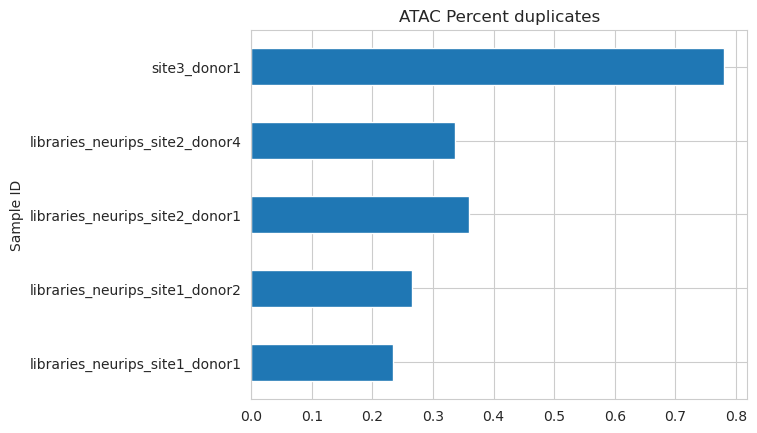

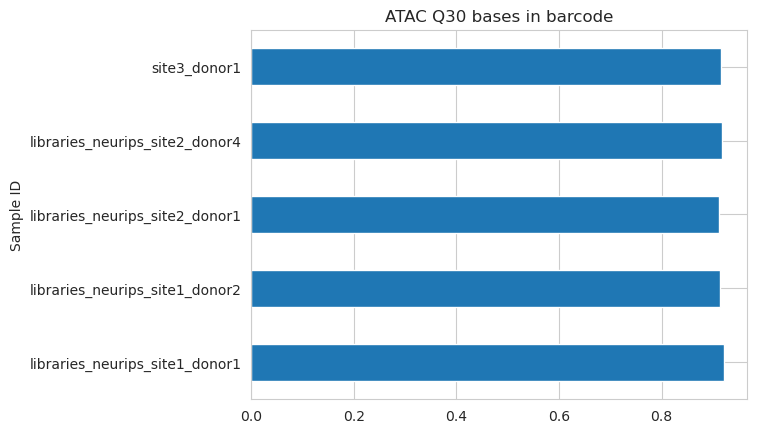

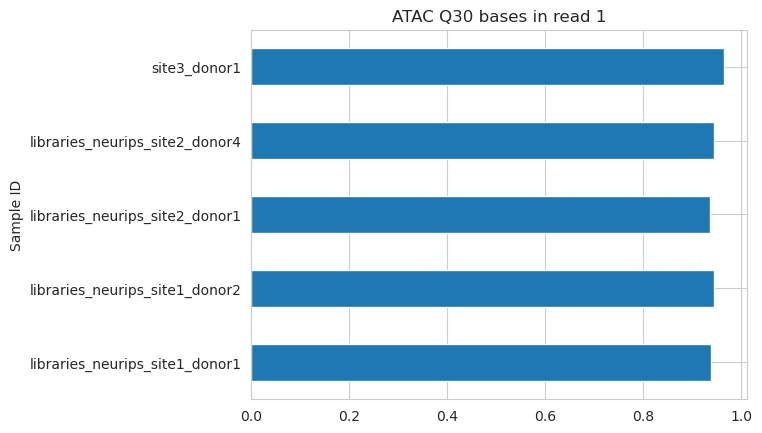

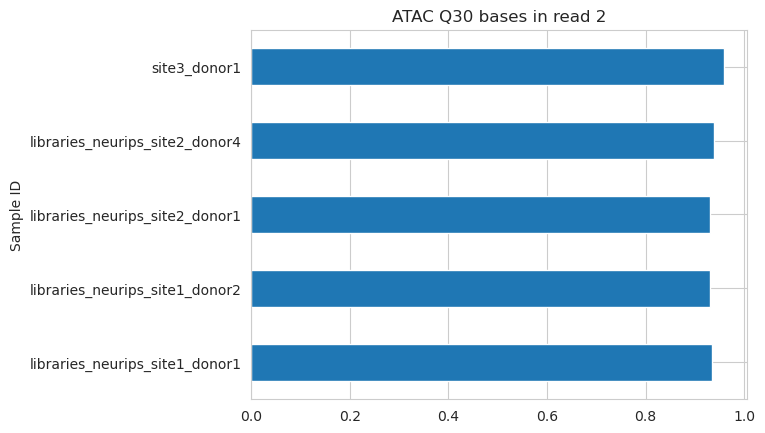

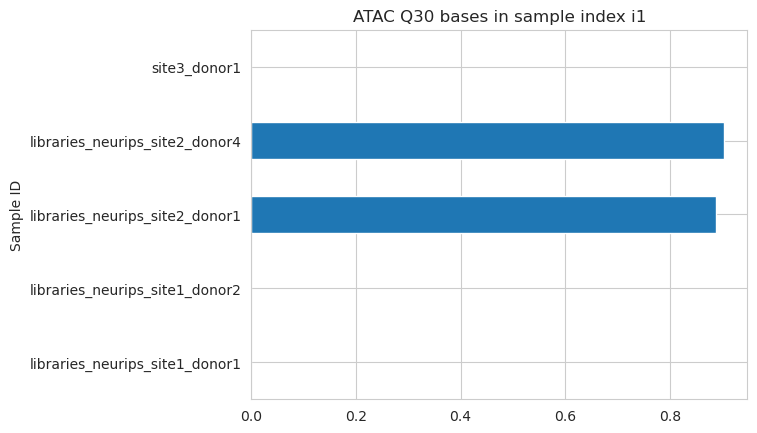

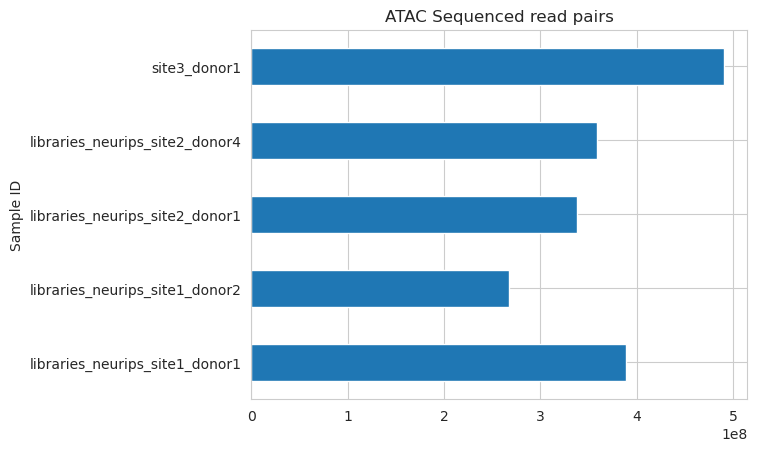

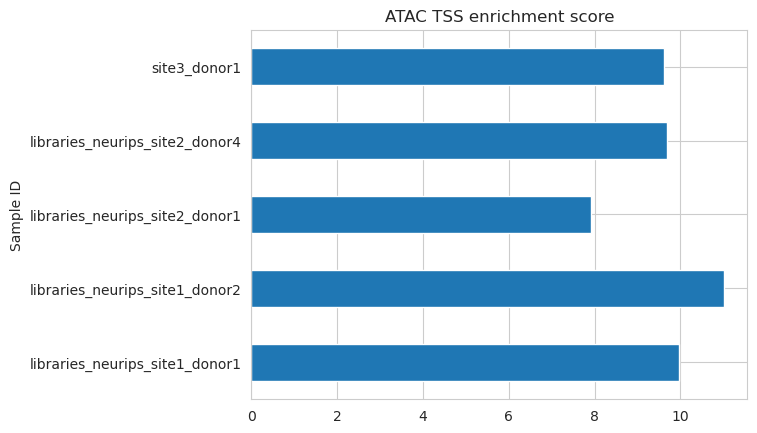

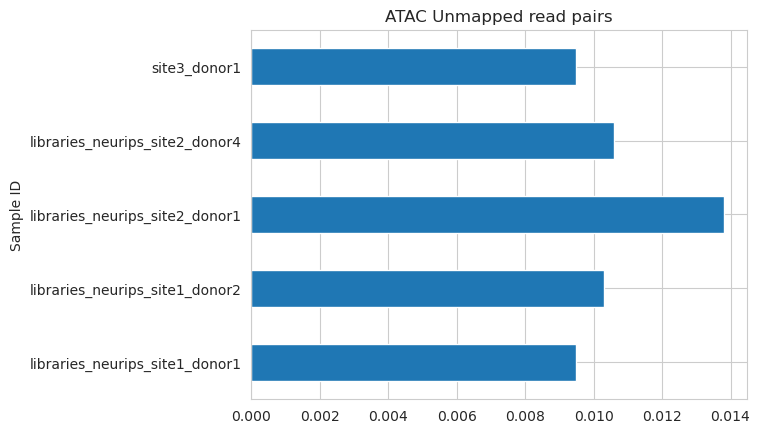

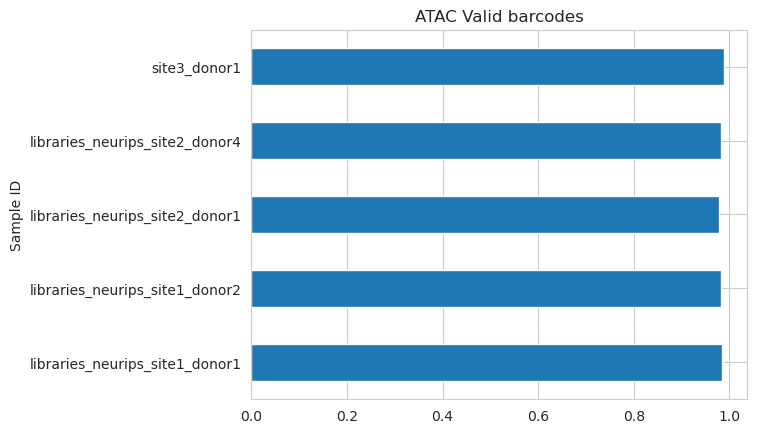

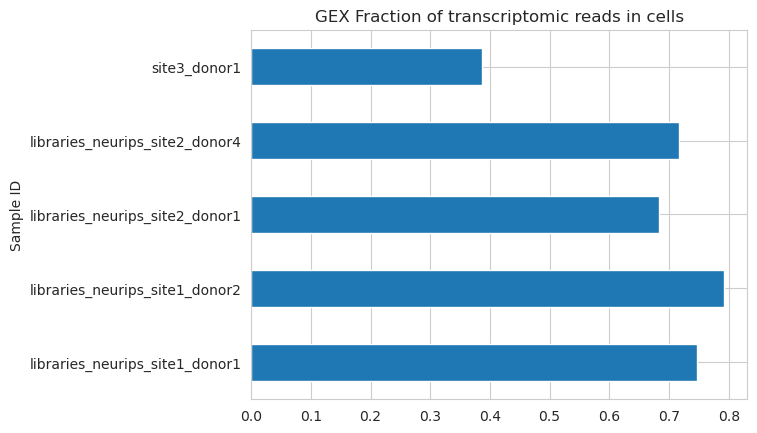

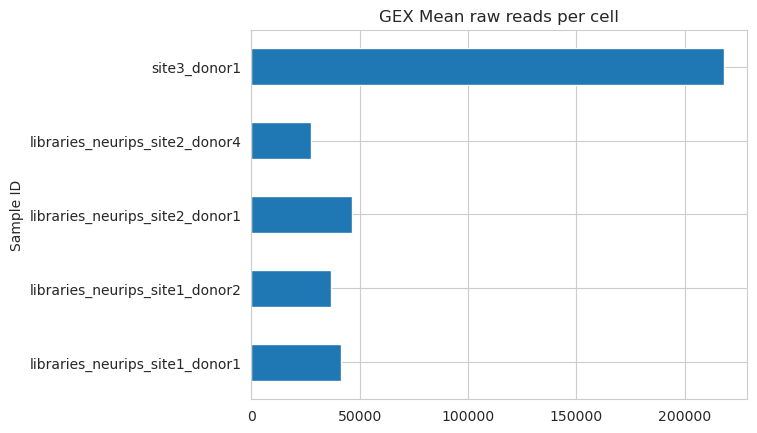

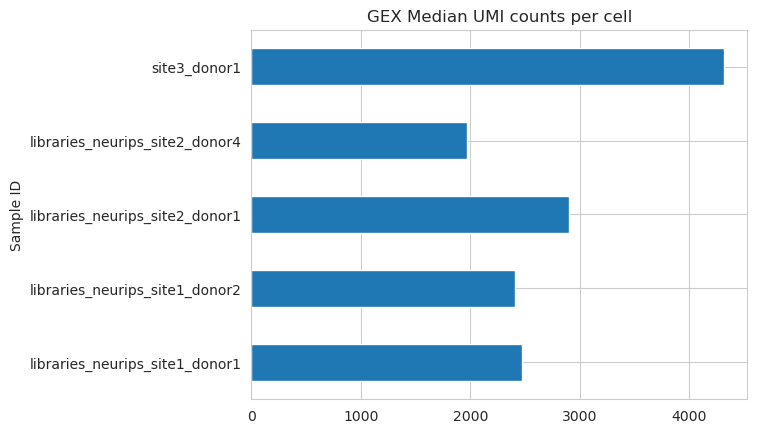

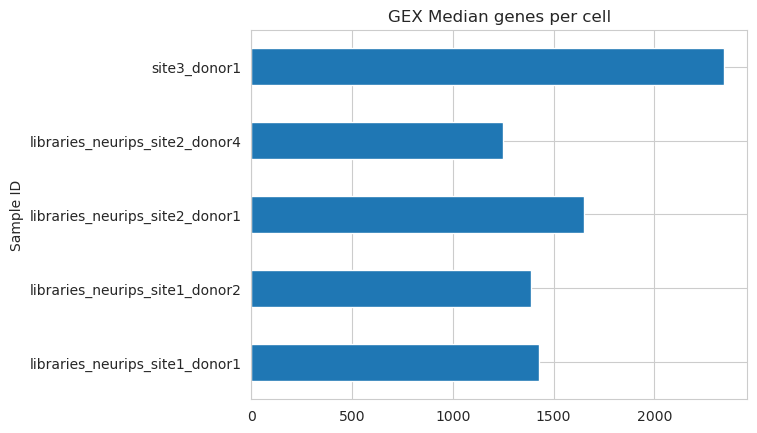

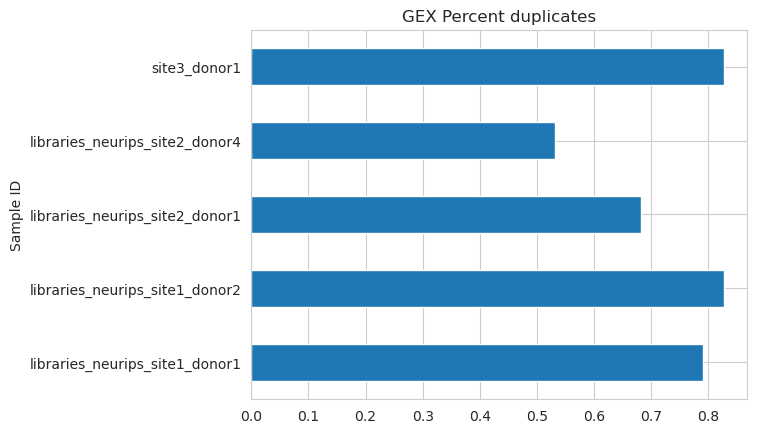

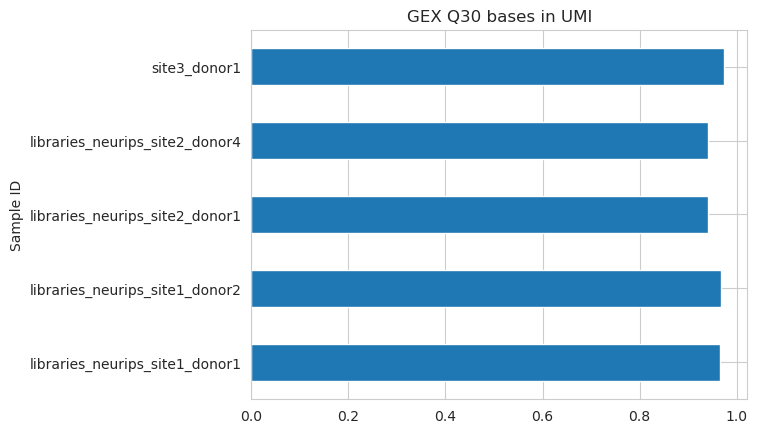

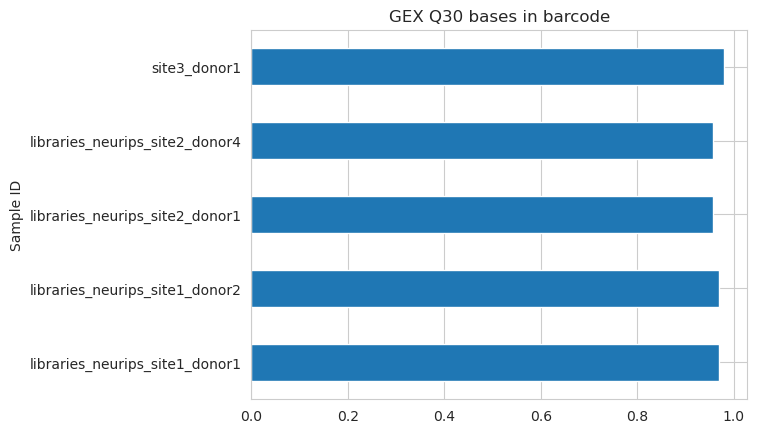

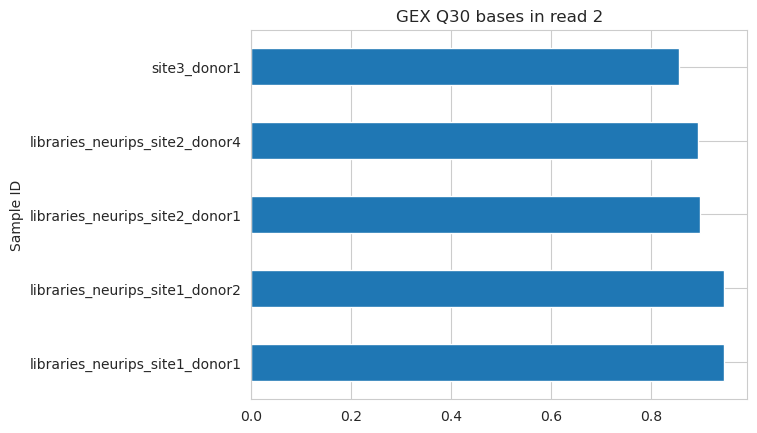

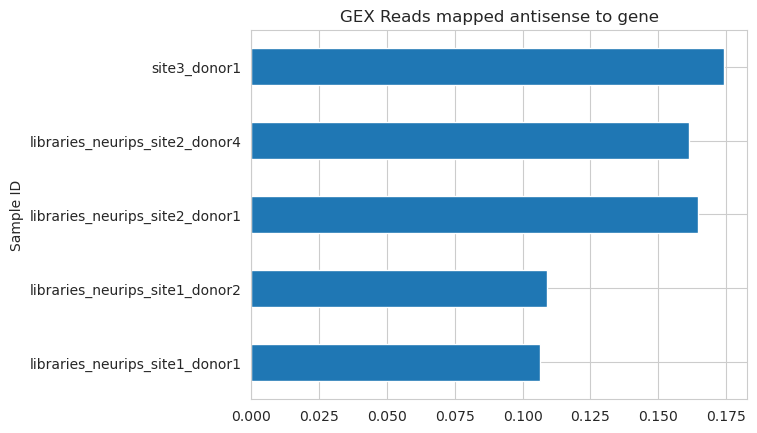

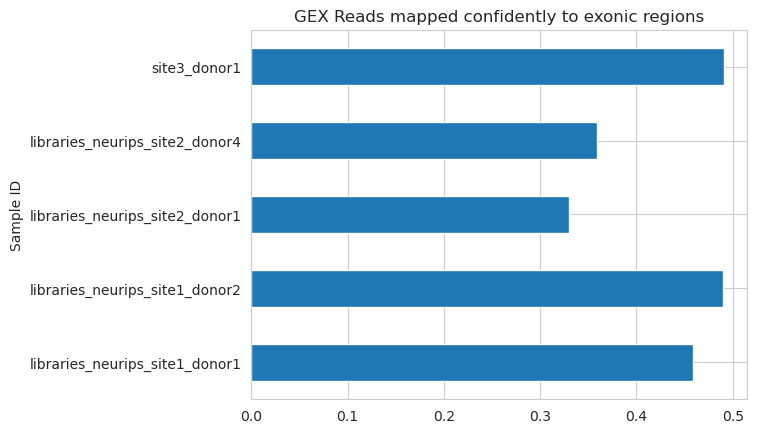

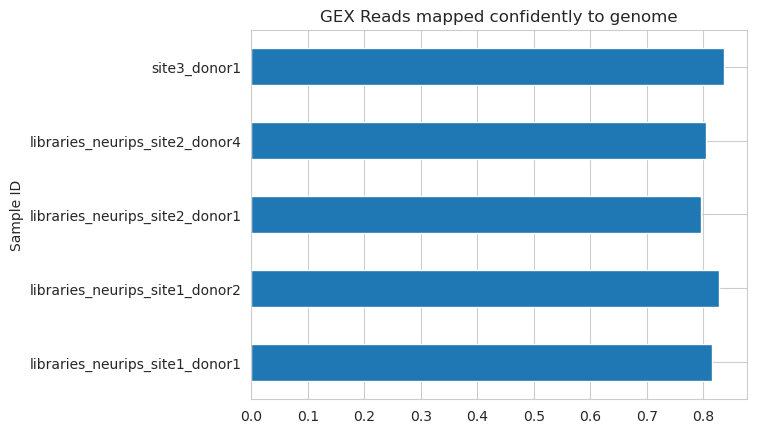

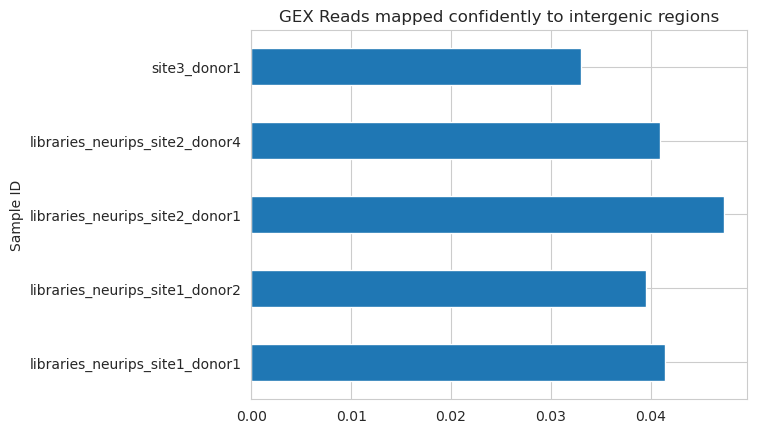

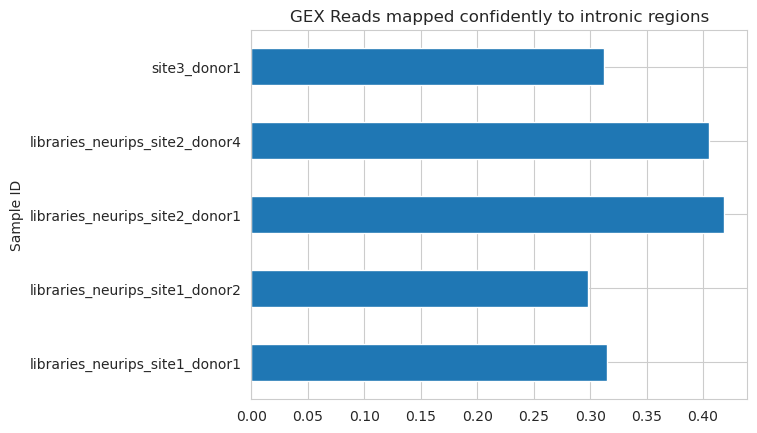

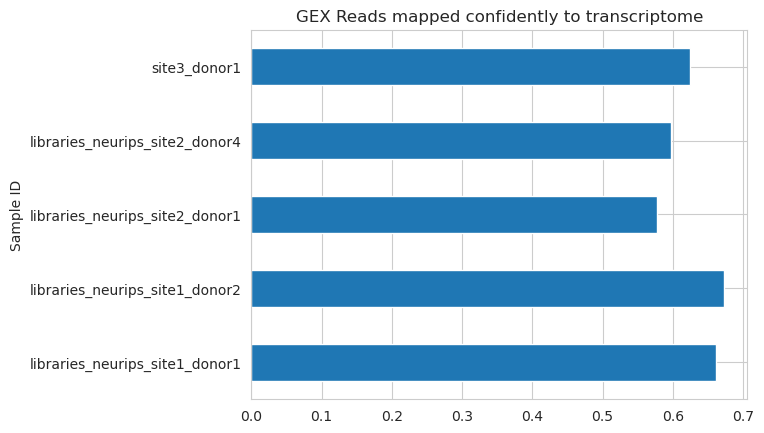

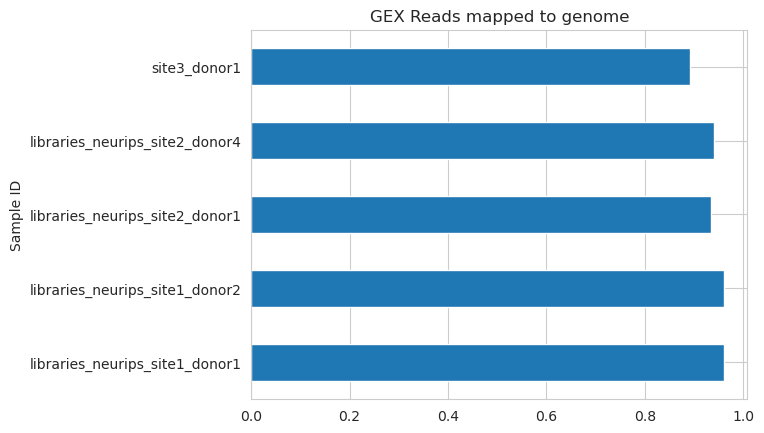

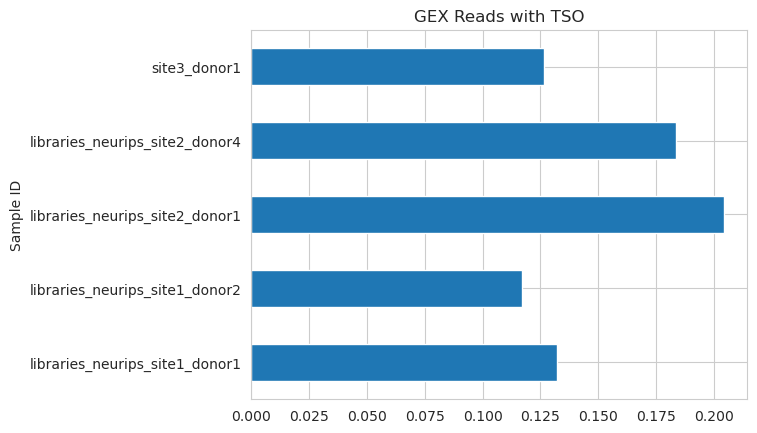

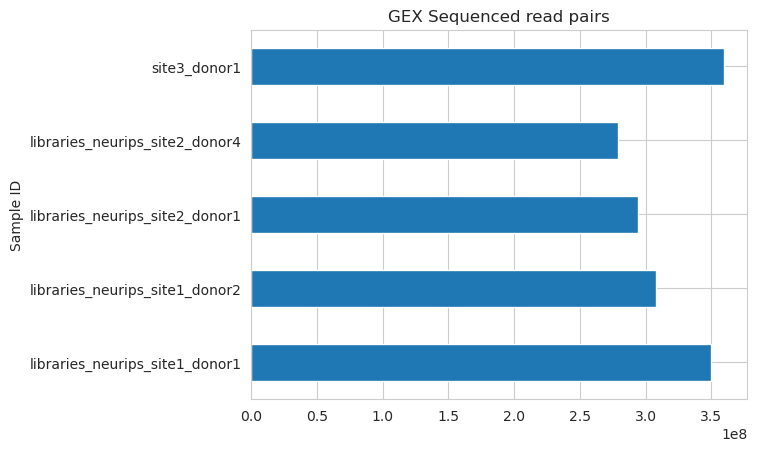

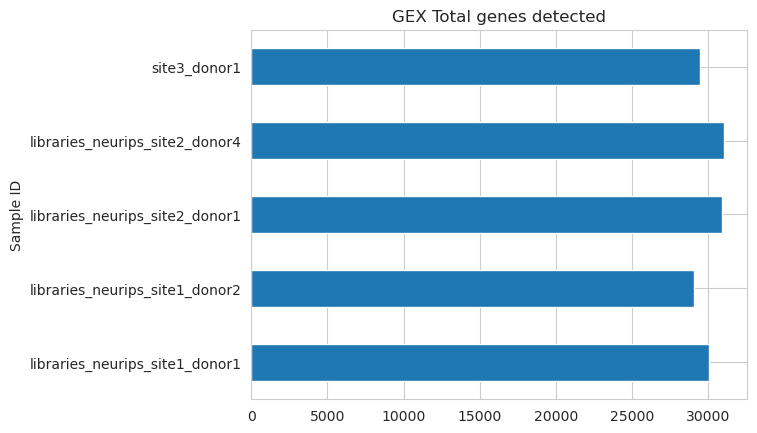

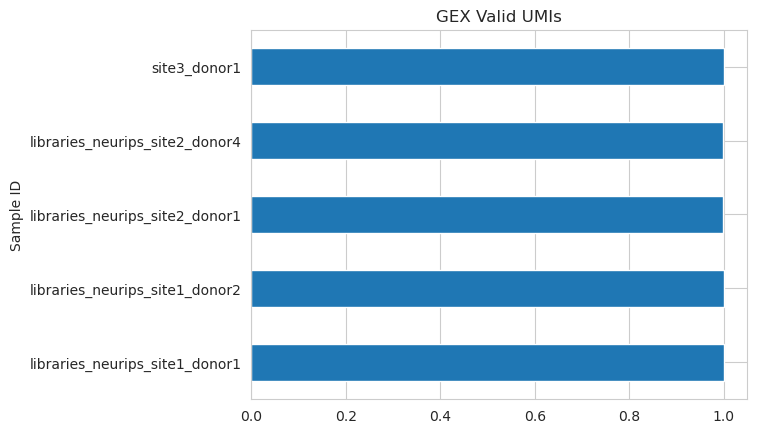

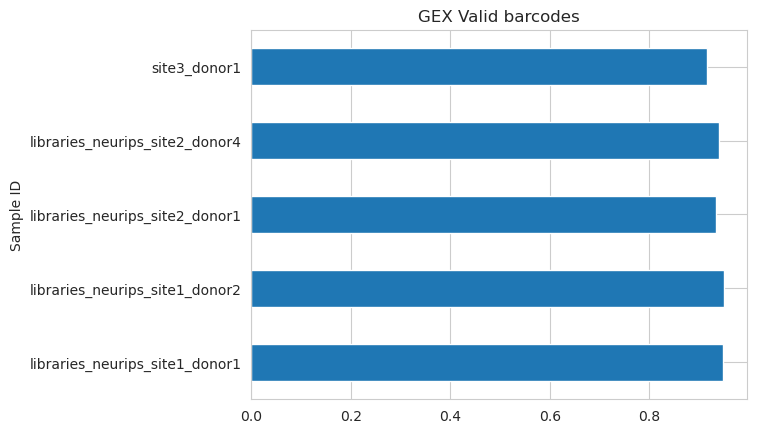

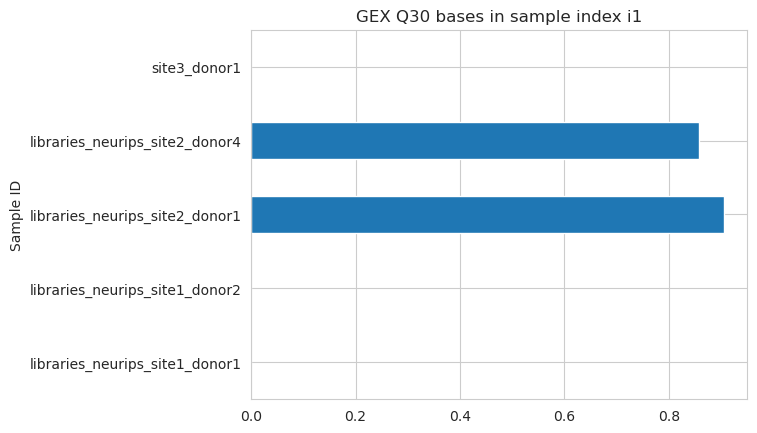

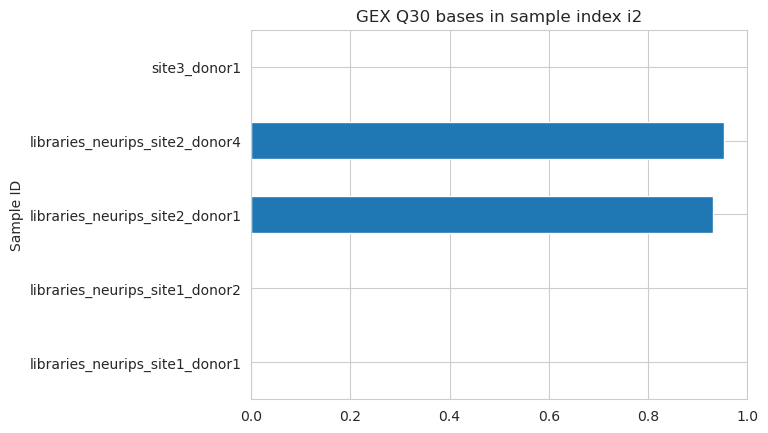

In [57]:
for c in samp_qc_df.columns:
    try:
        samp_qc_df[c].plot(kind='barh')
        plt.title(c)
        plt.show()
    except:
        continue


# Sample level QC

Next we check cell level QC metrics across samples to check for samples that might have general low quality.

For easier plotting, we first add the sample tags of the barcodes as a seperate column in .obs

In [40]:
atac.obs['samle_tag'] = [s.split('-')[1] for s in list(atac.obs_names)]

An first indicator for low quality samples can be the number of cells sequenced

In [41]:
# Get number of cells for each sample
n_cell_per_sample = atac.obs['samle_tag'].value_counts()
# Print number per sample
n_cell_per_sample

5    10062
1     8442
2     8341
4     6319
7     1649
Name: samle_tag, dtype: int64

Text(0.5, 1.0, 'QC across samples')

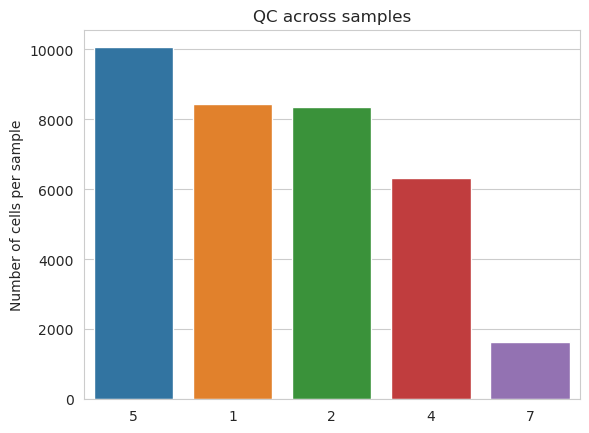

In [42]:
# Visualize as plot
sns.barplot(x = n_cell_per_sample.keys(), y=n_cell_per_sample.values)
plt.ylabel('Number of cells per sample')
plt.title('QC across samples')

The above plot shows there are less cells captured in sample 7. Let's take a look at additional QC metrics.

/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'nuc_signal_filter' as categorical
/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'samle_tag' as categorical
/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inp

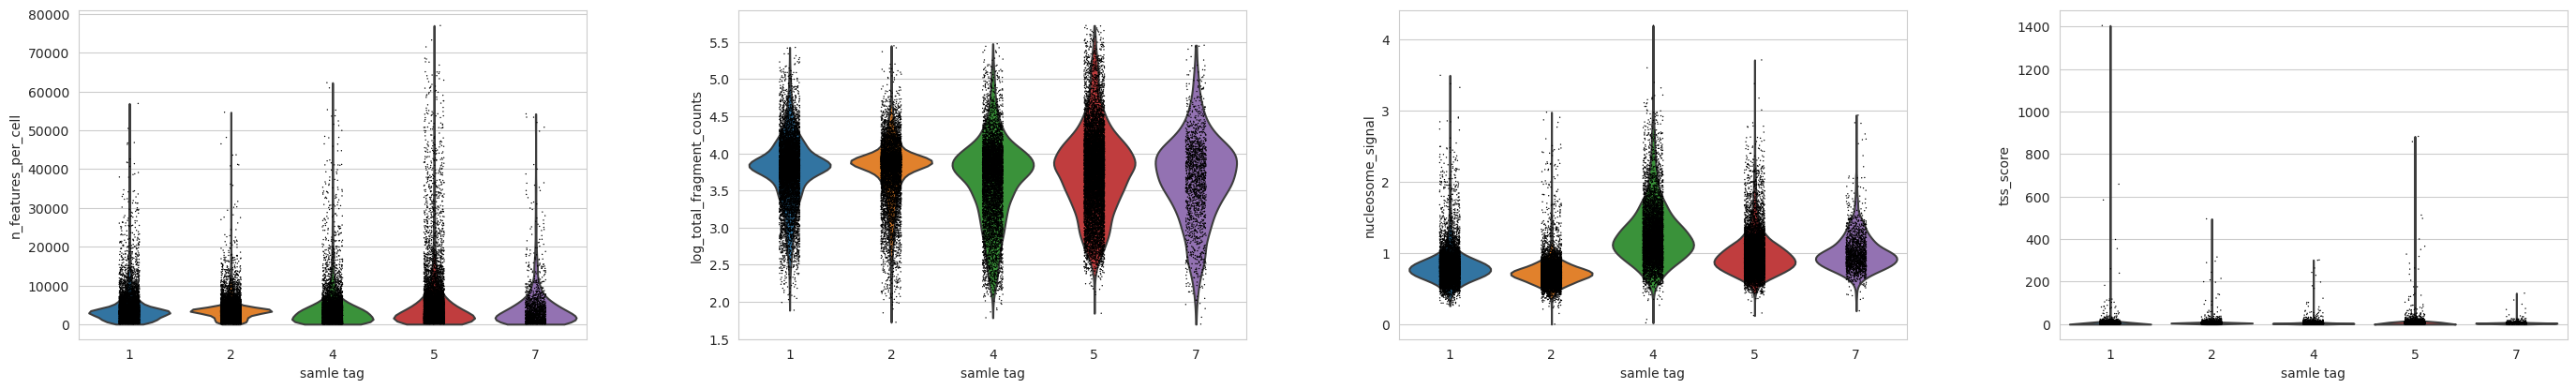

In [43]:
sc.pl.violin(atac, keys=['n_features_per_cell', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score'],
            groupby='samle_tag')

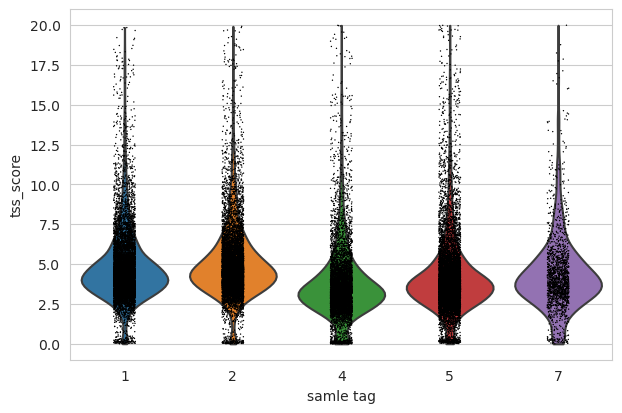

In [44]:
# Let's plot the TSS scores <20 for easier comparison
sc.pl.violin(atac[atac.obs.tss_score<20,:], keys=['tss_score'],
            groupby='samle_tag')

Based on the above plots there's not a clear indicator to remove sample 7 apart from a lower number of cells.
Therefore we don't exclude the sample, but keep in mind that there might be challenges during downstrem processing.

Since we do see differences in sample quality, we perform cell level QC per sample.

# Cell level QC

Let's look through a few istograms of QC metrics

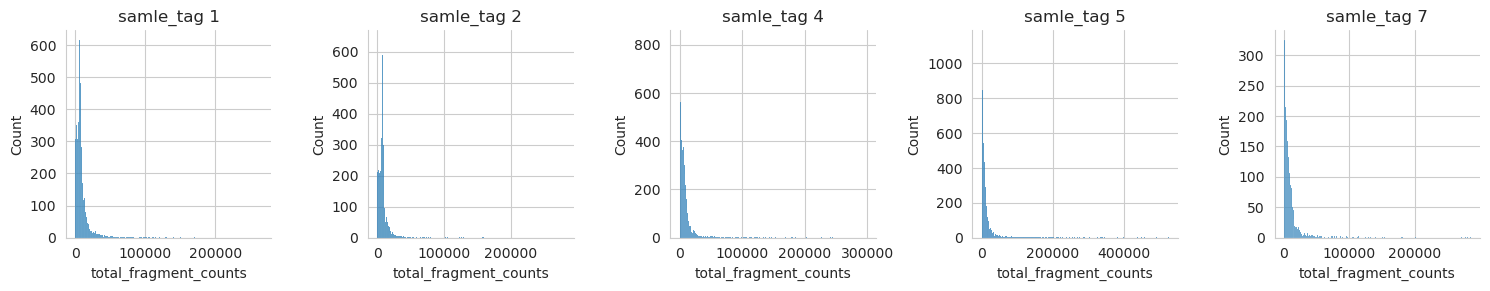

In [45]:
mu.pl.histogram(atac, ['total_fragment_counts'], groupby='samle_tag')

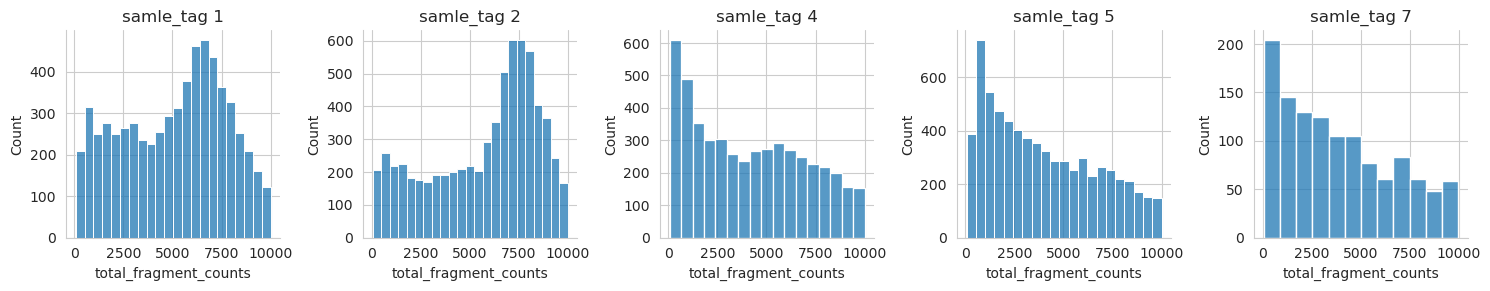

In [46]:
mu.pl.histogram(atac[atac.obs.total_fragment_counts<10000], ['total_fragment_counts'], groupby='samle_tag')

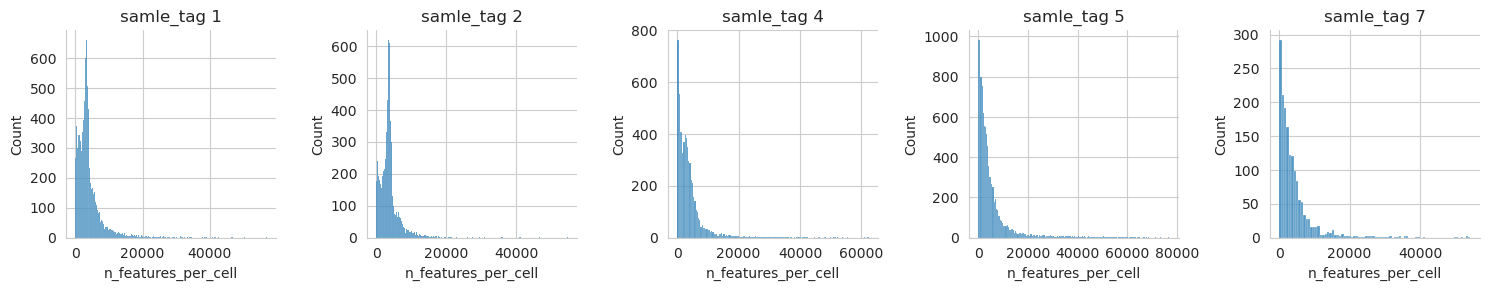

In [47]:
mu.pl.histogram(atac, ['n_features_per_cell'], groupby='samle_tag')

Decide on minimum cutoff number of features

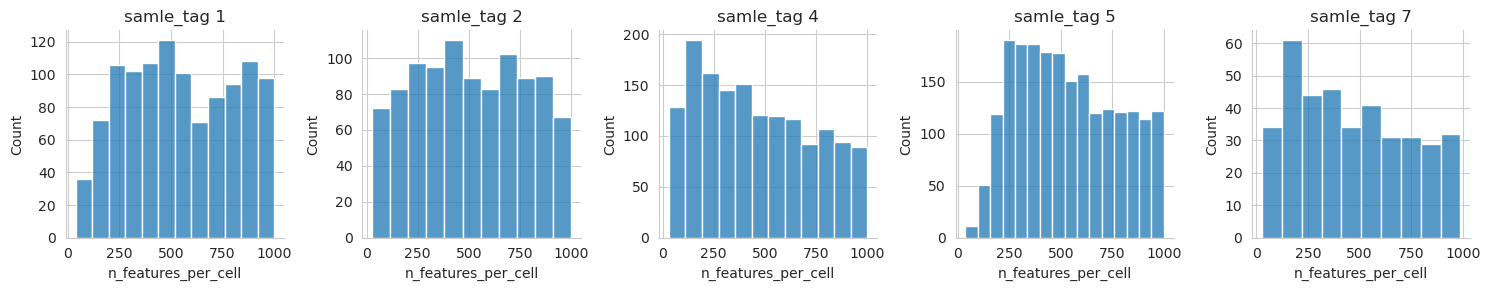

In [48]:
mu.pl.histogram(atac[atac.obs.n_features_per_cell<1000], ['n_features_per_cell'], groupby='samle_tag')

To find maximum cutoffs

/home/icb/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_fragment_counts', ylabel='n_features_per_cell'>

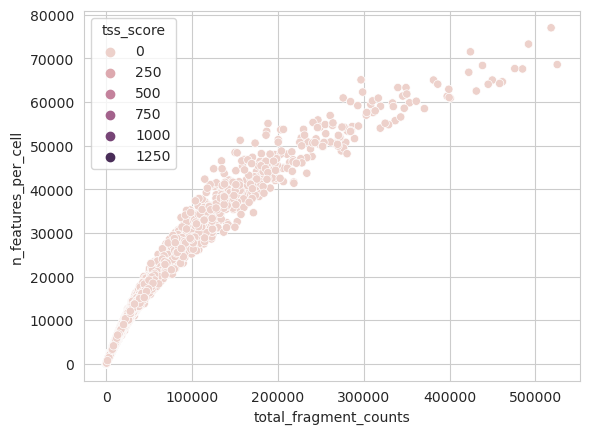

In [49]:
sns.scatterplot(atac.obs.total_fragment_counts,
                atac.obs.n_features_per_cell,
                hue=atac.obs.tss_score)

Next we plot for each sample a 2D hexbin plot with total number of fragments against the TSS enrichment score

In [50]:
# boundaries for plotting
plot_tss_max = 20

log_count_cutoff_lower = np.log10(1000)
log_count_cutoff_upper = np.log10(300000)
tss_cutoff = 1.5

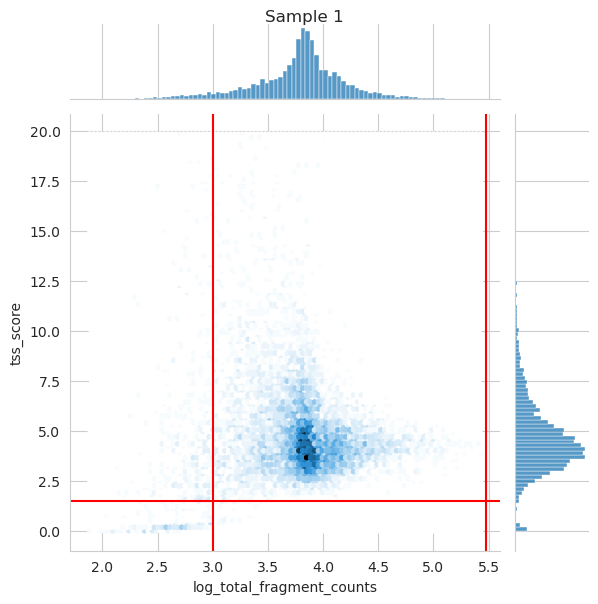

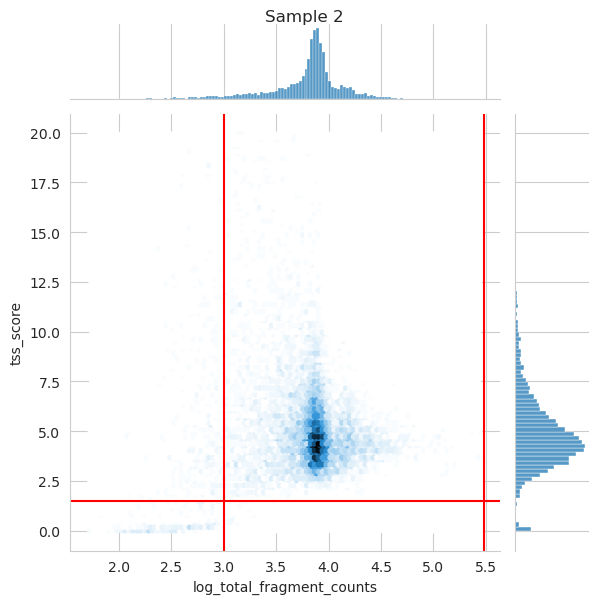

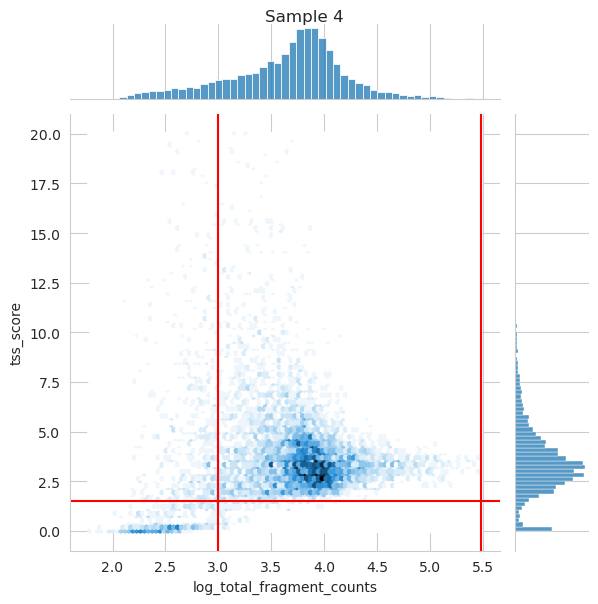

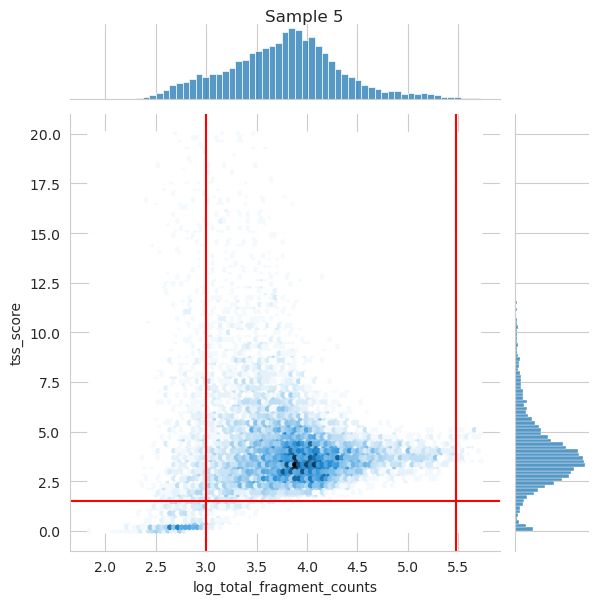

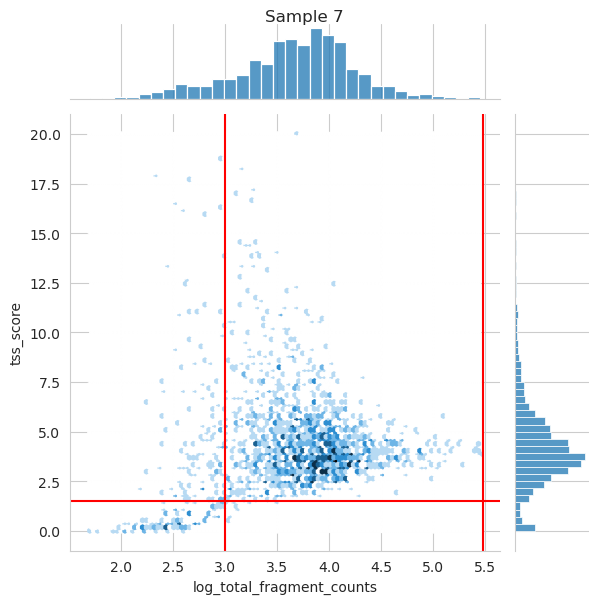

In [51]:
for s in samp_subset:
    atac_samp = atac[atac.obs.samle_tag==s]
    sns.jointplot(data=atac_samp[(atac_samp.obs["tss_score"]<plot_tss_max)].obs,
                  x="log_total_fragment_counts",
                  y="tss_score",
                  kind='hex', gridsize=100)
    
    plt.axvline(x=log_count_cutoff_lower, c='red')
    plt.axvline(x=log_count_cutoff_upper, c='red')
    plt.axhline(y=tss_cutoff, c='red')
    
    plt.suptitle("Sample "+s, y = 1)


# Filtering of cells and features

Here we select thresholds for filtering cells and features as follows:

- features:
    - should be detected in at least 10 cells


In [52]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

- cells:
    - number of features per cell > 750
    - number of detected fragments > 1000 and < 300000
    - TSS score > 1.5
    - Nucleosome signal > 3

In [53]:
mu.pp.filter_obs(atac, 'n_features_per_cell', lambda x: x >= 750)
mu.pp.filter_obs(atac, 'log_total_fragment_counts', lambda x: (x >= log_count_cutoff_lower) & (x <= log_count_cutoff_upper))

In [54]:
mu.pp.filter_obs(atac, 'tss_score', lambda x: x >= tss_cutoff)
mu.pp.filter_obs(atac, 'nucleosome_signal', lambda x: x <= 3)

In [55]:
# Save original counts
atac.layers["counts"] = atac.X

In [ ]:
atac

# Doublet detection - Adjust to ATAC!!

https://www.bioconductor.org/packages/devel/bioc/vignettes/scDblFinder/inst/doc/scATAC.html


In [36]:
import pandas as pd
import numpy as np

import anndata2ri
import logging
import warnings
warnings.filterwarnings('ignore')

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
library(Seurat)
library(scDblFinder)
library(scater)
library(BiocParallel)

In [ ]:
ata_mat = atac.X.T
sample_ids = pd.factorize(adata.obs['sample'])[0]

In [ ]:
%R -i data_mat -i sample_ids -o droplet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ), 
    samples=sample_ids, 
    BPPARAM=MulticoreParam(3), 
    verbose=TRUE
)
droplet_class = sce$scDblFinder.class

# Normalisation and dimensionality reduction

In [68]:
# backup w/o binarzation
atac_non_bin = atac.copy()

In [69]:
#??? check difference of binarization
ac.pp.binarize(atac)

In [70]:
ac.pp.tfidf(atac, scale_factor=1e4)
ac.tl.lsi(atac)

In [71]:
# check
atac.layers['tfidf'] = atac.X.copy()

In [72]:
# reset for total count norm
atac.X = atac.layers['counts']

In [73]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4, )
sc.pp.log1p(atac) #save as separate layer?

In [74]:
# check
atac.layers['total_log1p'] = atac.X.copy()

In [75]:
atac

AnnData object with n_obs × n_vars = 29916 × 158155
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'samle_tag', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files', 'samle_tag_colors', 'lsi', 'log1p'
    obsm: 'X_lsi'
    varm: 'LSI'
    layers: 'counts', 'tfidf', 'total_log1p'

In [76]:
ac.pp.tfidf(atac_non_bin, scale_factor=1e4)
ac.tl.lsi(atac_non_bin)

In [77]:
# check
atac_non_bin.layers['tfidf'] = atac_non_bin.X.copy()

In [78]:
atac_non_bin.X = atac_non_bin.layers['counts']

In [79]:
sc.pp.normalize_per_cell(atac_non_bin, counts_per_cell_after=1e4, )
sc.pp.log1p(atac_non_bin) #save as separate layer?

In [ ]:
sc.pp.pca()

In [80]:
# check
atac_non_bin.layers['total_log1p'] = atac_non_bin.X.copy()

In [81]:
atac_non_bin

AnnData object with n_obs × n_vars = 29916 × 158155
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'samle_tag', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files', 'samle_tag_colors', 'lsi', 'log1p'
    obsm: 'X_lsi'
    varm: 'LSI'
    layers: 'counts', 'tfidf', 'total_log1p'

# Correlation of LSI and PCs with total counts

In [ ]:
# get correlation

# 

In [82]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

# Visualization - LSI

In [83]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [84]:
sc.tl.leiden(atac, resolution=.5)

In [85]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

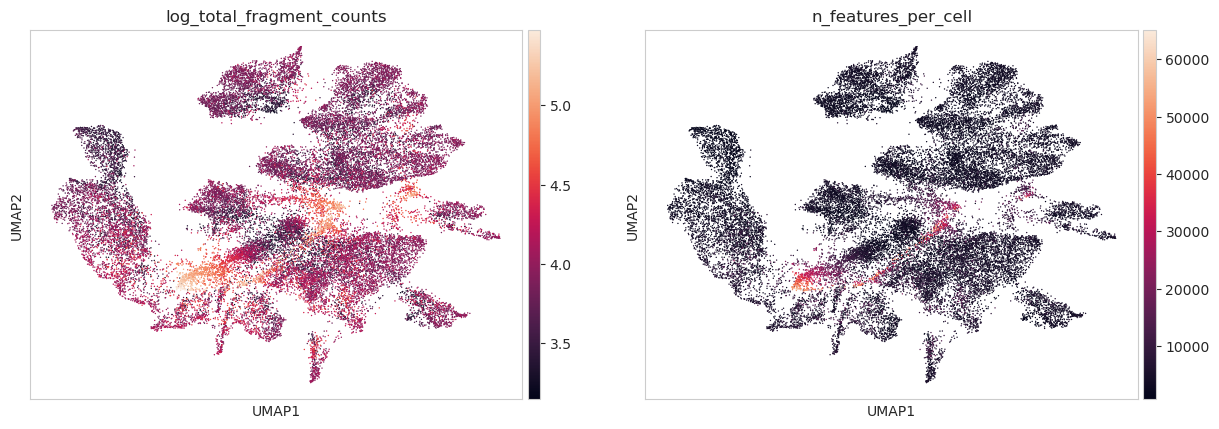

In [90]:
sc.pl.umap(atac, color=["log_total_fragment_counts", "n_features_per_cell"], legend_loc="on data")

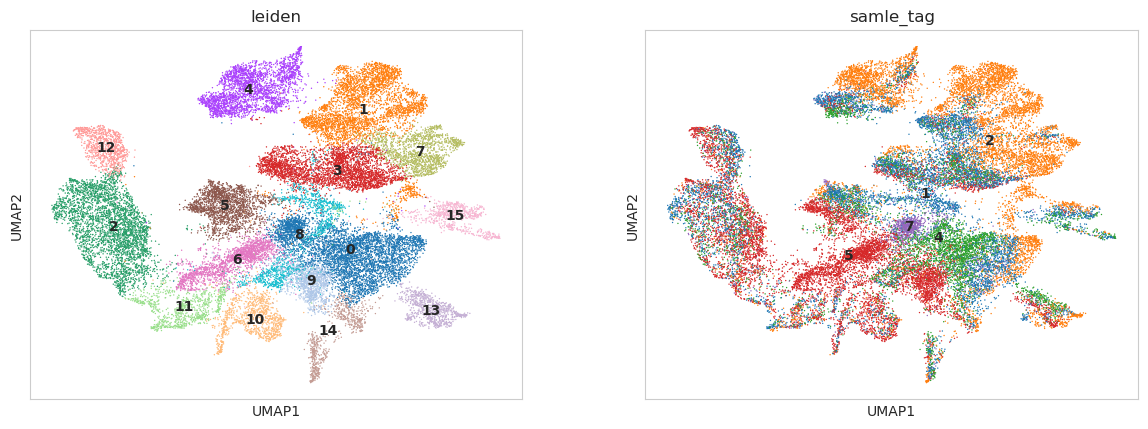

In [89]:
sc.pl.umap(atac, color=["leiden", "samle_tag"], legend_loc="on data")

Sample 7 seems to have not much substructure!

In [93]:
# doublet score
# sc.pl.umap(atac, color=["doublet_score"], legend_loc="on data")

# Visualization - PCA

In [83]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [84]:
sc.tl.leiden(atac, resolution=.5)

In [85]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

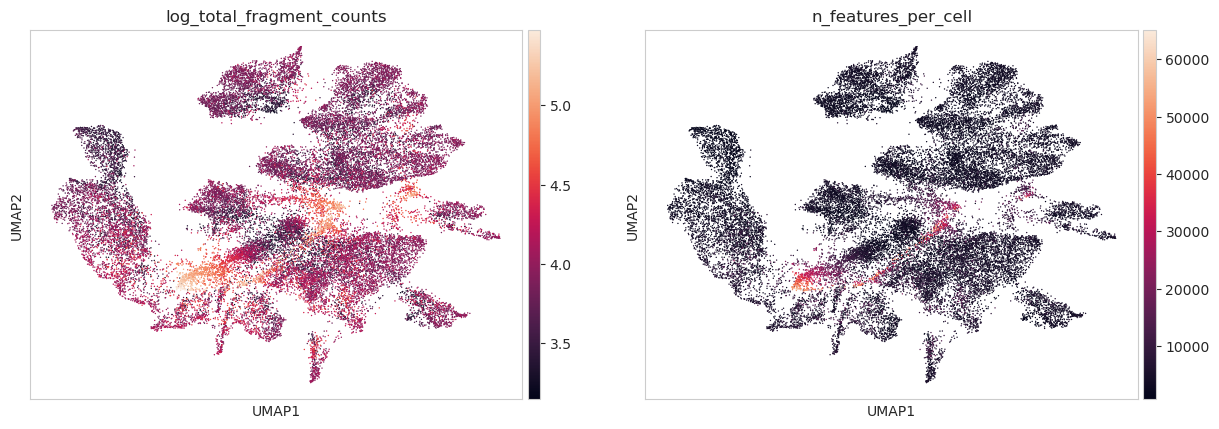

In [90]:
sc.pl.umap(atac, color=["log_total_fragment_counts", "n_features_per_cell"], legend_loc="on data")

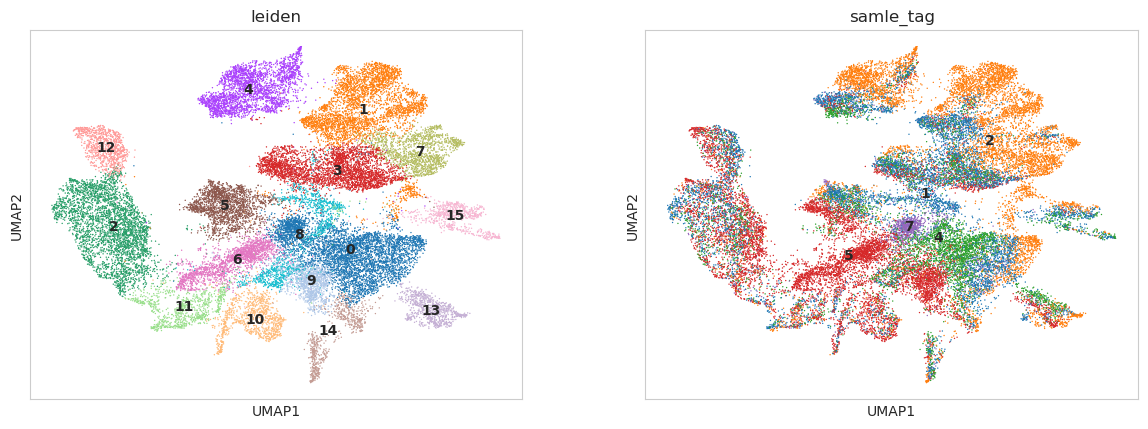

In [89]:
sc.pl.umap(atac, color=["leiden", "samle_tag"], legend_loc="on data")

Sample 7 seems to have not much substructure!

In [93]:
# doublet score
# sc.pl.umap(atac, color=["doublet_score"], legend_loc="on data")

## Substructure per sample